# Lab 8 - BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Modelos Generativos

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Predição de série temporal com redes recorrentes (RNN)

Data da entrega : 21/10

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-LabX.pdf"
- Envie o PDF via google [FORM](https://forms.gle/zX7Va67EVzdXarbLA)

Este notebook é baseado em tensorflow e Keras.

# Predição de preço de criptomoedas com redes recorrentes

Informação sobre o Bitcoin : https://www.kaggle.com/ibadia/bitcoin-101-bitcoins-and-detailed-insights


O valor de uma criptomoeda, assim como um ativo financeiro do mercado de ações, pode ser configurado com uma série temporal. Aqui, consideraremos o valor ponderado do preço diário do Bitcoin para constuir nossa série. O objetivo deste estudo é predizer o próximo valor, baseado nos últimos valores da criptomoeda. Para tal, usaremos de redes recorrentes, pois as mesmas tem memória, o que é importante quando se trata de dados sequenciais.


## Carregando os pacotes

In [1]:
# Importa as bibliotecas necessárias
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Vamos usar o pacote ***quandl*** para baixar diretamente dados fornecidos por uma corretora de criptomoedas (Kraken).

In [2]:
!pip install quandl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Carregando os dados

In [3]:
# baixa os dados da exchange Kraken, até o período atual.
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')


## Entendendo os dados

In [4]:
#exibe as primeiras linahs 
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2713 entries, 2014-01-07 to 2021-06-20
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               2713 non-null   float64
 1   High               2713 non-null   float64
 2   Low                2713 non-null   float64
 3   Close              2713 non-null   float64
 4   Volume (BTC)       2713 non-null   float64
 5   Volume (Currency)  2713 non-null   float64
 6   Weighted Price     2713 non-null   float64
dtypes: float64(7)
memory usage: 169.6 KB


In [6]:
# verifica os últimos dados. Repare na data. Deve ter dados atuais (Jun / 2021).
data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2021-06-16,40167.3,40493.0,38120.0,38337.1,6487.206888,2.539206e+08,39141.737747
2021-06-17,38337.1,39561.4,37405.0,38078.2,6003.220618,2.307246e+08,38433.468618
2021-06-18,38078.2,38193.1,35126.0,35824.0,6558.468890,2.409217e+08,36734.445103
2021-06-19,35824.0,36450.0,34901.0,35490.5,4485.076656,1.603145e+08,35743.971502
2021-06-20,35484.2,36112.2,33370.0,35668.7,6229.513564,2.168125e+08,34804.086189


Repare que temos dados de abertura do pregão, fechamento, valor mais alto, valor mais baixo, volume diário do bitcoin e de todas as criptomoedas combinadas. E também, temos os preço ponderado pelos valores de compra/venda de um período, que em nosso caso é diário. Para facilitar, vamos usar o valor ponderado.

## Plotando os dados

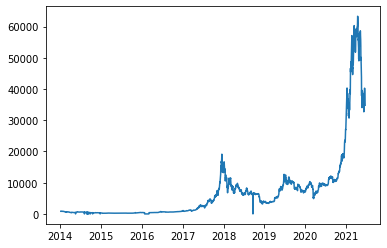

In [7]:
# imprima os dados
pyplot.plot(data['Weighted Price'])

## Pré-processamento dos dados

In [10]:
#existem alguns pontos com valor zero (outliers), vamos trocar por NaN e depois chamar um método para preencher os valores vazios
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

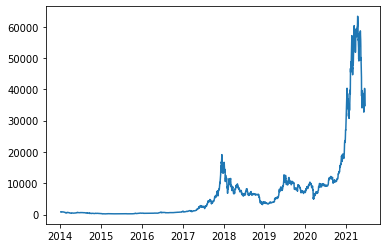

In [11]:
# imprima novamente e observe que não existe mais estes outliers.
pyplot.plot(data['Weighted Price'])

In [13]:
# vamos usar o preço ponderado como entrada para nossa rede recorrente
# como já vimos, eh sempre bom normalizar os dados para ajudar na convergência do treinamento
# Normaliza na faixa entre [0 e 1]
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [15]:
# vamos deixar 70% para treino e 30% para teste. Observe que temos mais de 6 anos de dados.
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1899 814


In [18]:
train.shape

(1899, 1)

Vamos considerar uma janela de um único dia para efetuar a predição. Para isso, use a função create_dataset(..) e deixe o parâmetro look_back=1. O parâmetro look_back controla a quantidade de dados que vai fazer parte da janela de entrada para a rede. Estude e entenda o que a função faz.

In [20]:
#função para criar os conjuntos de dados de treino
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [21]:
# entra com janela de 1 único valor
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1898
813


In [24]:
trainX.shape, trainY.shape

((1898, 1), (1898,))

In [27]:
testX.shape, testY.shape

((813, 1), (813,))

In [28]:
# reshape para formato de entrada da rede neural (instancias, 1, 1)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [29]:
trainX.shape

(1898, 1, 1)

In [30]:
testX.shape

(813, 1, 1)

## Projeto de uma rede recorrente

Projete uma rede recorrente, usando alguma das camadas abaixo:

```
  tf.keras.layers.LSTM
  tf.keras.layers.GRU
  tf.keras.layers.RNN
```

As camadas recorrentes (LSTM, GRU, RNN) podem ser bidirecionais ou simples, por exemplo, uma camada LSTM com 32 unidades e bidirecional:

 ```
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
 ```

Você também pode usar dropout e camadas densas em seu modelo. 

Experimente três arquiteturas (rasas e profundas) e pelo menos dois algoritmos de otimização. Documente os resultados em uma tabela e anexe.

 Por exemplo, você pode usar um modelo raso como o abaixo:

```
 np.random.seed(42)
 tf.random.set_seed(42)


 model_1 = Sequential([
   LSTM(128,input_shape=[None,1]),
   Dense(1)
 ])
```

Com uma função de custo **Mean Square Error** e o algoritmo de otimização **ADAM**:

```
 model_1.compile(loss='mse',optimizer = 'adam')
```

Ou pode usar um modelo profundo, mais complexo como o abaixo:

```
 model = Sequential()
 model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
 model.add(Dense(units = 64, activation='relu'))
 model.add(Dropout(dropout_rate))
 model.add(Dense(units = 1))
```

O **erro médio quadrático** deste último modelo, com o otimizador **ADAM** e **erro médio quadrático** como função de custo deve resultar em:

```
 Test Root Mean Square Error (RMSE): 380.139
```

### Observações
1. **Seu RMSE pode ser diferente devido aos dados usados.**
2. **Use modelos diferentes dos de exemplo!**


 

## ToDo: Projetando os seus modelos (30pt)

In [ ]:
# Camadas LSTM, GRU, RNN - Bidirecionais ou simples
# 3 arquiteturas (rasas e profundas) 
# 2 algoritmos de otimização
# Dropout e camadas densas 

#### Modelo 1:

In [113]:
# ToDO : projete o modelo aqui
# Rasa
model1 = Sequential()
model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, input_shape=[None,1])))
model1.add(Dense(units = 64, activation='relu'))
model1.add(Dense(units = 1))
#model1.compile(loss=tf.keras.losses.MSE,optimizer = tf.keras.optimizers.Adam())

#### Modelo 2:

In [114]:
# ToDO : projete o modelo aqui
#Profunda
model2 = Sequential()
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, input_shape=[None,1])))
model2.add(Dense(units = 128, activation='relu'))
model2.add(Dense(units = 64, activation='relu'))
model2.add(Dense(units = 32, activation='relu'))
model2.add(Dense(units = 32, activation='relu'))
model2.add(Dense(units = 16, activation='relu'))
model2.add(Dense(units = 16, activation='relu'))
model2.add(Dense(units = 1))
#model2.compile(loss=tf.keras.losses.MSE,optimizer = tf.keras.optimizers.Adam())

#### Modelo 3:

In [129]:
# ToDO : projete o modelo aqui
model3 = Sequential()
model3.add(tf.keras.layers.SimpleRNN(256, input_shape=[None,1]))
model3.add(Dense(units = 32, activation='relu'))
model3.add(Dense(units = 32, activation='relu'))
model3.add(Dense(units = 32, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.01))
model3.add(Dense(units = 16, activation='relu'))
model3.add(Dense(units = 1))
#model3.compile(loss=tf.keras.losses.MAE,optimizer = tf.keras.optimizers.Adamax())

## ToDo: Função de custo (10pt)

Como é um problema de regressão, usaremos funções de custo apropriadas. Você pode usar, por exemplo, *Mean Absolute Error* (mae) ou *Mean Squared Error* (mse). 

**ToDo:** Estude as funções de custo MAE e MSE. Qual das duas funções você usaria. Justifique sua escolha. Repare que vamos avaliar os modelos pela métrica *Root Mean Square Error* (RMSE).

O MSE penaliza os erros de maior magnitude, pois eleva ao quadrado o resultado do erro, sendo muito alto em base de dados que possuem muitos outliers, diferente do MAE que utiliza valores absolutos dos erros. Nesse caso, seria melhor a utilização do MSE, pois vai acentuar mais os erros, e se o MSE for baixo então o modelo terá um bom poder preditivo.

## ToDo: Função para treinar o seu modelo (15pt)

In [116]:
# Função para treinar o modelo
def train_model(model, loss, optimizer, trainX, trainY):
  # Compile o modelo : atenção para a função de CUSTO. Abaixo um exemplo de uso da 'mae'
  model.compile(loss=loss, optimizer=optimizer)

  #treine o modelo
  history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50) # todo...

  # plote a curva de custo
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()

  pyplot.show()



## Função para avaliar o seu modelo


In [117]:
# Avaliando o modelo treinado
def evaluate_model(model, testX, testY):

  # plote as curvas, valor real e valor predito no mesmo gráfico
  yhat = model.predict(testX)
  pyplot.title('Curva do valor real e valor predito na escala usado no treino')
  pyplot.plot(yhat, label='predict')
  pyplot.plot(testY, label='true')
  pyplot.legend()
  pyplot.show()
  
  # os valores foream normalizados para o treinamento. 
  # Veja que para fazer sentido, eles devem voltar para a escala original.
  # Volta para escala em US dollar :
  yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
  testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

  # calcula o RMSE 
  rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
  print('Test RMSE: %.3f' % rmse)

  # valor em US dollar
  pyplot.title('Curva do valor real e valor predito em US dollar')
  pyplot.plot(yhat_inverse, label='predict')
  pyplot.plot(testY_inverse, label='actual', alpha=0.5)
  pyplot.legend()
  pyplot.show()

## ToDo: Treinando e avaliando o seu modelo (15pt)

### Modelo 1

Epoch 1/50
60/60 [==============================] - 5s 21ms/step - loss: 8.8028e-04 - val_loss: 0.0014
Epoch 2/50
60/60 [==============================] - 0s 6ms/step - loss: 1.5069e-05 - val_loss: 0.0033
Epoch 3/50
60/60 [==============================] - 0s 6ms/step - loss: 1.2750e-05 - val_loss: 0.0030
Epoch 4/50
60/60 [==============================] - 0s 6ms/step - loss: 1.2196e-05 - val_loss: 0.0030
Epoch 5/50
60/60 [==============================] - 0s 7ms/step - loss: 1.2767e-05 - val_loss: 0.0026
Epoch 6/50
60/60 [==============================] - 0s 6ms/step - loss: 1.6106e-05 - val_loss: 0.0028
Epoch 7/50
60/60 [==============================] - 0s 6ms/step - loss: 1.2993e-05 - val_loss: 0.0024
Epoch 8/50
60/60 [==============================] - 0s 6ms/step - loss: 1.2672e-05 - val_loss: 0.0027
Epoch 9/50
60/60 [==============================] - 0s 6ms/step - loss: 1.3238e-05 - val_loss: 0.0028
Epoch 10/50
60/60 [==============================] - 0s 6ms/step - loss: 1.5125e-

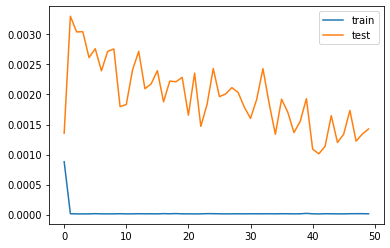

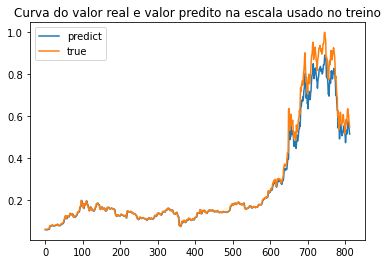

Test RMSE: 2383.538


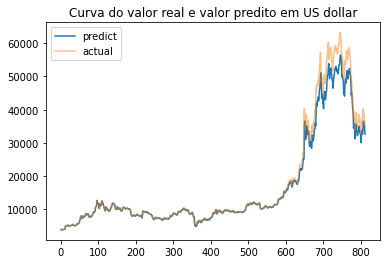

In [118]:
# Modelo 1
train_model(model1, tf.keras.losses.MSE, tf.keras.optimizers.Adam(), trainX, trainY)
evaluate_model(model1, testX, testY)

### Modelo 2

Epoch 1/50
60/60 [==============================] - 7s 26ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 2/50
60/60 [==============================] - 1s 12ms/step - loss: 1.7515e-05 - val_loss: 0.0025
Epoch 3/50
60/60 [==============================] - 1s 12ms/step - loss: 1.8951e-05 - val_loss: 0.0029
Epoch 4/50
60/60 [==============================] - 1s 13ms/step - loss: 1.5745e-05 - val_loss: 0.0029
Epoch 5/50
60/60 [==============================] - 1s 12ms/step - loss: 2.5711e-05 - val_loss: 0.0027
Epoch 6/50
60/60 [==============================] - 1s 12ms/step - loss: 1.7850e-05 - val_loss: 0.0042
Epoch 7/50
60/60 [==============================] - 1s 12ms/step - loss: 2.8531e-05 - val_loss: 0.0046
Epoch 8/50
60/60 [==============================] - 1s 11ms/step - loss: 2.1339e-05 - val_loss: 0.0018
Epoch 9/50
60/60 [==============================] - 1s 11ms/step - loss: 1.5850e-05 - val_loss: 0.0035
Epoch 10/50
60/60 [==============================] - 1s 11ms/step - loss: 1.6

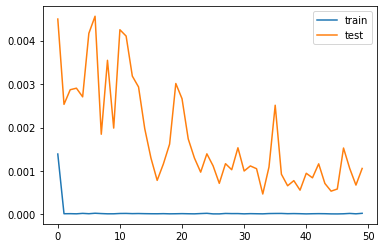

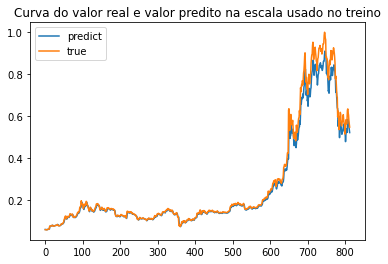

Test RMSE: 2054.306


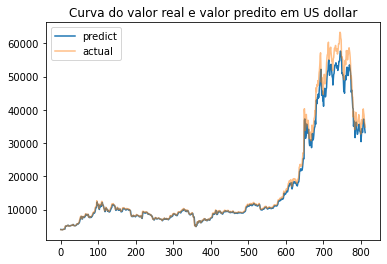

In [119]:
# Modelo 2
train_model(model2, tf.keras.losses.MSE, tf.keras.optimizers.Adam(), trainX, trainY)
evaluate_model(model2, testX, testY)

### Modelo 3

Epoch 1/50
60/60 [==============================] - 5s 24ms/step - loss: 0.0033 - val_loss: 0.0125
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0109
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0113
Epoch 4/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0125
Epoch 5/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0107
Epoch 6/50
60/60 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0119
Epoch 7/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0124
Epoch 8/50
60/60 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0086
Epoch 9/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0100
Epoch 10/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0090
Epoch 11/

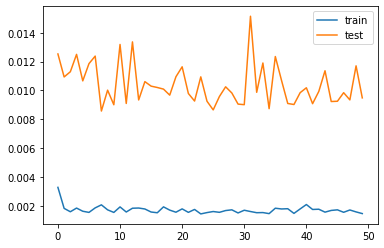

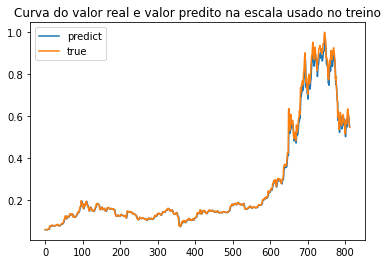

Test RMSE: 1228.596


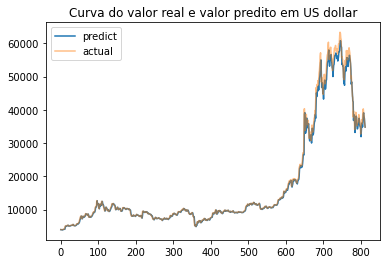

In [130]:
# Modelo 3
train_model(model2, tf.keras.losses.MAE, tf.keras.optimizers.Adamax(), trainX, trainY)
evaluate_model(model2, testX, testY)

O Modelo 3 foi o que mais se ajustou a curva de Predição, depois o Modelo 2, e por último o Modelo 1.

## Prevendo o próximo dia

In [121]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def baseline(history):
  return np.mean(history)
  
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  pyplot.title(title)
  for i, x in enumerate(plot_data):
    if i:
      pyplot.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      pyplot.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  pyplot.legend()
  pyplot.xlim([time_steps[0], (future+5)*2])
  pyplot.xlabel('Time-Step')
  return pyplot

### ToDo: Função para predizer o próximo dia (15pt)

In [122]:
def predict_next_day(model, testX, testY):
  # os valores foram normalizados para o treinamento. 
  # Veja que para fazer sentido, eles devem voltar para a escala original.
  # Volta para escala em US dollar :
  yhat_inverse = scaler.inverse_transform(model.predict(testX).reshape(-1, 1))
  testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

  # na base de teste, plote até a instância 200 e tente predizer a instância futura: 201
  # use a função show_plot
  show_plot([testY_inverse[0:200], yhat_inverse[201],
             baseline(testY_inverse[201])], 1, 'Predição do dia seguinte')
  
  print('valor predito do dia 201: ', yhat_inverse[201])
  print('Valor real do dia 201: ', testY_inverse[201])

#### Modelo 1:

valor predito do dia 201:  [8159.112]
Valor real do dia 201:  [8431.232]


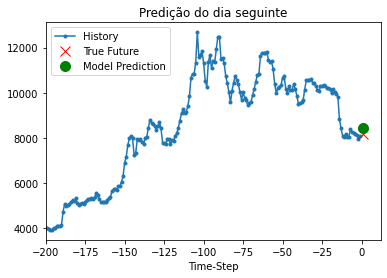

In [126]:
# ToDo: seu código
predict_next_day(model1, testX, testY)

#### Modelo 2:

valor predito do dia 201:  [8181.3506]
Valor real do dia 201:  [8431.232]


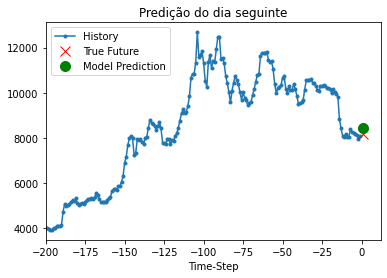

In [127]:
# ToDo: seu código
predict_next_day(model2, testX, testY)

#### Modelo 3:

valor predito do dia 201:  [-818.1589]
Valor real do dia 201:  [8431.232]


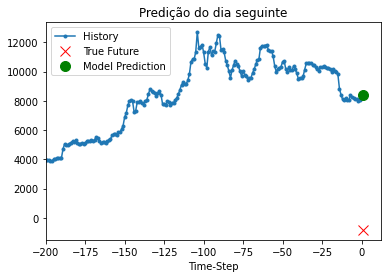

In [132]:
# ToDo: seu código
predict_next_day(model3, testX, testY)

O Modelo 2 chegou mais perto da predição correta para o dia 201.

## ToDo: Resultados (15pt)

Coloque os valores dos modelos em uma tabela. Em cada coluna, informe qual a função de custo utilizada, qual otimizador e o erro na partição de teste em RMSE.

```
   ------------------------------------------------------
   | Modelo   | Função de Custo | Otimizador | RMSE     |
   ------------------------------------------------------
   | Modelo 1 |         MSE     |    ADAM    | 2383.538 |
   | Modelo 2 |         MSE     |    ADAM    | 2054.306 |
   | Modelo 3 |         MAE     |    ADAMMAX | 1228.596 |
   ------------------------------------------------------
```


O Modelo 3 teve o menor erro no Treinamento, e obteve um melhor resultado na validação.